In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, GRU, Dense, Dropout, Bidirectional
from keras_tuner import HyperModel, RandomSearch
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [18]:
# Load and preprocess the data
StockData = pd.read_csv(r"D:\target\ml\Stock_MARKET_PREDICTION\HistoricalQuotes.csv")
StockData['Date'] = pd.to_datetime(StockData['Date'])
StockData = StockData.sort_values('Date')

In [19]:
# Remove dollar signs and convert to float
StockData[' Close/Last'] = StockData[' Close/Last'].replace('[\$,]', '', regex=True).astype(float)
StockData[' Open'] = StockData[' Open'].replace('[\$,]', '', regex=True).astype(float)
StockData[' High'] = StockData[' High'].replace('[\$,]', '', regex=True).astype(float)
StockData[' Low'] = StockData[' Low'].replace('[\$,]', '', regex=True).astype(float)

<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:3: SyntaxWarning: invalid escape sequence '\$'
<>:4: SyntaxWarning: invalid escape sequence '\$'
<>:5: SyntaxWarning: invalid escape sequence '\$'
<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:3: SyntaxWarning: invalid escape sequence '\$'
<>:4: SyntaxWarning: invalid escape sequence '\$'
<>:5: SyntaxWarning: invalid escape sequence '\$'
C:\Users\Asus\AppData\Local\Temp\ipykernel_7552\2745802837.py:2: SyntaxWarning: invalid escape sequence '\$'
  StockData[' Close/Last'] = StockData[' Close/Last'].replace('[\$,]', '', regex=True).astype(float)
C:\Users\Asus\AppData\Local\Temp\ipykernel_7552\2745802837.py:3: SyntaxWarning: invalid escape sequence '\$'
  StockData[' Open'] = StockData[' Open'].replace('[\$,]', '', regex=True).astype(float)
C:\Users\Asus\AppData\Local\Temp\ipykernel_7552\2745802837.py:4: SyntaxWarning: invalid escape sequence '\$'
  StockData[' High'] = StockData[' High'].replace('[\$,]', '', regex=True).astype(f

In [20]:
# Feature Engineering (Add more technical indicators)
StockData['SMA_50'] = StockData[' Close/Last'].rolling(window=50).mean()
StockData['SMA_200'] = StockData[' Close/Last'].rolling(window=200).mean()
StockData['EMA_50'] = StockData[' Close/Last'].ewm(span=50, adjust=False).mean()
StockData['EMA_200'] = StockData[' Close/Last'].ewm(span=200, adjust=False).mean()

In [21]:
StockData.head()

,Date,Close/Last,Volume,Open,High,Low,SMA_50,SMA_200,EMA_50,EMA_200
2517,2010-03-01,29.8557,137312041,29.3928,29.9286,29.3500,NaN,NaN,29.855700,29.855700
2516,2010-03-02,29.8357,141486282,29.9900,30.1186,29.6771,NaN,NaN,29.854916,29.855501
2515,2010-03-03,29.9043,92846488,29.8486,29.9814,29.7057,NaN,NaN,29.856852,29.855987
2514,2010-03-04,30.1014,89591907,29.8971,30.1314,29.8043,NaN,NaN,29.866442,29.858428
2513,2010-03-05,31.2786,224647427,30.7057,31.3857,30.6614,NaN,NaN,29.921821,29.872560


In [22]:
StockData.describe()

,Date,Close/Last,Volume,Open,High,Low,SMA_50,SMA_200,EMA_50,EMA_200
count,2518,2518.000000,2.518000e+03,2518.000000,2518.000000,2518.000000,2469.000000,2319.000000,2518.000000,2518.000000
mean,2015-02-26 15:01:17.204130304,114.769522,7.258009e+07,114.728443,115.766415,113.690582,113.643078,111.626364,112.131486,105.858729
min,2010-03-01 00:00:00,29.835700,1.136205e+07,29.392800,29.928600,28.464300,34.084788,38.025390,29.854916,29.855501
25%,2012-08-24 18:00:00,66.822475,3.053026e+07,66.877150,67.475300,66.372950,68.730242,71.281352,66.991154,68.009692
50%,2015-02-28 12:00:00,101.090000,5.295469e+07,101.115000,102.085000,100.350000,101.836800,104.549999,100.983576,103.048082
75%,2017-08-27 06:00:00,154.630000,9.861006e+07,154.610000,155.735000,153.325000,155.682200,148.882225,153.836118,140.026769
max,2020-02-28 00:00:00,327.200000,4.624423e+08,324.740000,327.850000,323.350000,306.505400,241.833025,304.598887,255.356970
std,NaN,60.662405,5.663113e+07,60.546893,61.134456,60.085105,57.103035,49.834604,57.728244,52.784758


In [23]:
StockData.shape

(2518, 10)

In [24]:
features = [' Close/Last', 'SMA_50', 'SMA_200', 'EMA_50', 'EMA_200']
StockData = StockData.dropna(subset=features)

# Define the scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(StockData[features])

In [25]:
# Train-test split (80% train, 20% test)
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Prepare sequences for LSTM/RNN/GRU
sequence_length = 60
X_train, y_train = [], []
for i in range(sequence_length, len(train_data)):
    X_train.append(train_data[i-sequence_length:i])
    y_train.append(train_data[i, 0])  # Predict 'Close/Last'

In [26]:
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))  # Shape for LSTM, RNN, GRU


In [27]:
X_test, y_test = [], []
for i in range(sequence_length, len(test_data)):
    X_test.append(test_data[i-sequence_length:i])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))  # Shape for LSTM, RNN, GRU


In [28]:
from sklearn.model_selection import train_test_split

# Split X_train and y_train into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [29]:
class EnhancedModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        
        # Use GRU, LSTM, or Bidirectional LSTM based on hyperparameter
        rnn_type = hp.Choice('rnn_type', values=['LSTM', 'GRU', 'BidirectionalLSTM'], default='LSTM')
        units = hp.Int('units', min_value=50, max_value=200, step=50)

        if rnn_type == 'LSTM':
            model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        elif rnn_type == 'GRU':
            model.add(GRU(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        else:  # Bidirectional LSTM
            model.add(Bidirectional(LSTM(units=units, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
        
        model.add(Dropout(0.2))
        
        model.add(LSTM(units=units, return_sequences=False))
        model.add(Dropout(0.2))
        
        model.add(Dense(units=25))
        model.add(Dense(units=1))  # Output layer for the prediction

        model.compile(optimizer='adam', loss='mean_absolute_percentage_error')
        return model


In [30]:
from kerastuner import RandomSearch

tuner = RandomSearch(
    EnhancedModel(),
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='time_series_rnn'
)

tuner.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val))



Trial 10 Complete [00h 00m 49s]
val_loss: 4179.56591796875

Best val_loss So Far: 21.605087280273438
Total elapsed time: 00h 07m 53s


In [31]:
# # Define a selection function if you have multiple models
# def select_best_model(models, X_val, y_val):
#     best_score = float('inf')
#     best_model = None

#     for model in models:
#         predictions = model.predict(X_val)
#         score = mean_squared_error(y_val, predictions)
#         if score < best_score:
#             best_score = score
#             best_model = model
    
#     return best_model

# # Assuming lstm_model and rnn_model exist, add them to the list
# best_model = select_best_model([lstm_model, rnn_model], X_val, y_val)



C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Ensemble Model RMSE: 0.012356729794400473
Ensemble Model MAE: 0.010066987603948824
Ensemble Model R2: 0.9719982847378358


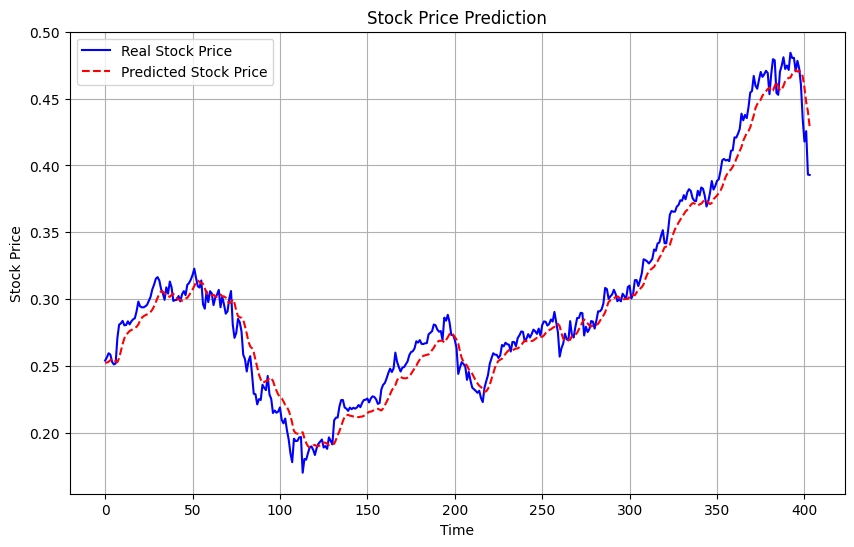

In [32]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(y_train.reshape(-1, 1))  # Fit only on training data
best_model = tuner.get_best_models(num_models=1)[0]

# Predict with the best model
lstm_predictions = best_model.predict(X_test)
lstm_predictions = lstm_predictions.reshape(-1, 1)  # Reshape to match the scaler

# Inverse transform predictions to original scale
lstm_predictions_rescaled = scaler.inverse_transform(lstm_predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse_ensemble = np.sqrt(mean_squared_error(y_test_rescaled, lstm_predictions_rescaled))
mae_ensemble = mean_absolute_error(y_test_rescaled, lstm_predictions_rescaled)
r2_ensemble = r2_score(y_test_rescaled, lstm_predictions_rescaled)

print(f"Ensemble Model RMSE: {rmse_ensemble}")
print(f"Ensemble Model MAE: {mae_ensemble}")
print(f"Ensemble Model R2: {r2_ensemble}")

plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, color='blue', label='Real Stock Price')
plt.plot(lstm_predictions_rescaled, color='red', linestyle='--', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()







